In [1]:
import numpy as np
import tensorflow as tf

# Instead of using Keras API to feed image into the model,
# we need our own Variable tensor so we can use it directly.
input_tn = tf.Variable(np.empty([1, 224, 224, 3]), dtype='float32')

# Note that we load the model without any fully connected layer,
# since we do no need them in this notebook.
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16(input_tensor=input_tn, include_top=False, input_shape=(224, 224, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from utils import plot_image, load_tiny_batch, plot_images_grid

# Loads a tiny batch of images from Internet
images_raw = load_tiny_batch()
plot_images_grid(images_raw)

In [3]:
import numpy as np
from utils import crop_and_resize_for_imagenet

# Cropped and/or resized into ImageNet shape 224x244x3 array of type uint8 [0, 255]
images_resized = np.array([crop_and_resize_for_imagenet(i) for i in images_raw.values()])

# Rescaled RGB distribution to match ImageNet
# images_rescaled = preprocess_input(images_resized)

In [4]:
images_resized.shape

(4, 224, 224, 3)

In [5]:
# Note that we need to get Tenserflow session from Keras,
# because it's the only session where VGG16 is initialized
# with the pre-trained weights. New sessions have random initialization.
s = tf.keras.backend.get_session()

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (1, 224, 224, 3)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (1, 224, 224, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (1, 224, 224, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (1, 112, 112, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (1, 112, 112, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (1, 112, 112, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (1, 56, 56, 128)          0         
__________

In [7]:
# In order to visualize the first layer's kernels directly,
# we can look at the list weights and choose the first convolution.
variables = {w.name:w for w in model.weights}
variables

{'block1_conv1/kernel:0': <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>,
 'block1_conv1/bias:0': <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>,
 'block1_conv2/kernel:0': <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>,
 'block1_conv2/bias:0': <tf.Variable 'block1_conv2/bias:0' shape=(64,) dtype=float32>,
 'block2_conv1/kernel:0': <tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32>,
 'block2_conv1/bias:0': <tf.Variable 'block2_conv1/bias:0' shape=(128,) dtype=float32>,
 'block2_conv2/kernel:0': <tf.Variable 'block2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32>,
 'block2_conv2/bias:0': <tf.Variable 'block2_conv2/bias:0' shape=(128,) dtype=float32>,
 'block3_conv1/kernel:0': <tf.Variable 'block3_conv1/kernel:0' shape=(3, 3, 128, 256) dtype=float32>,
 'block3_conv1/bias:0': <tf.Variable 'block3_conv1/bias:0' shape=(256,) dtype=float32>,
 'block3_conv2/kernel:0': <tf.Variable 'block3_conv2/kerne

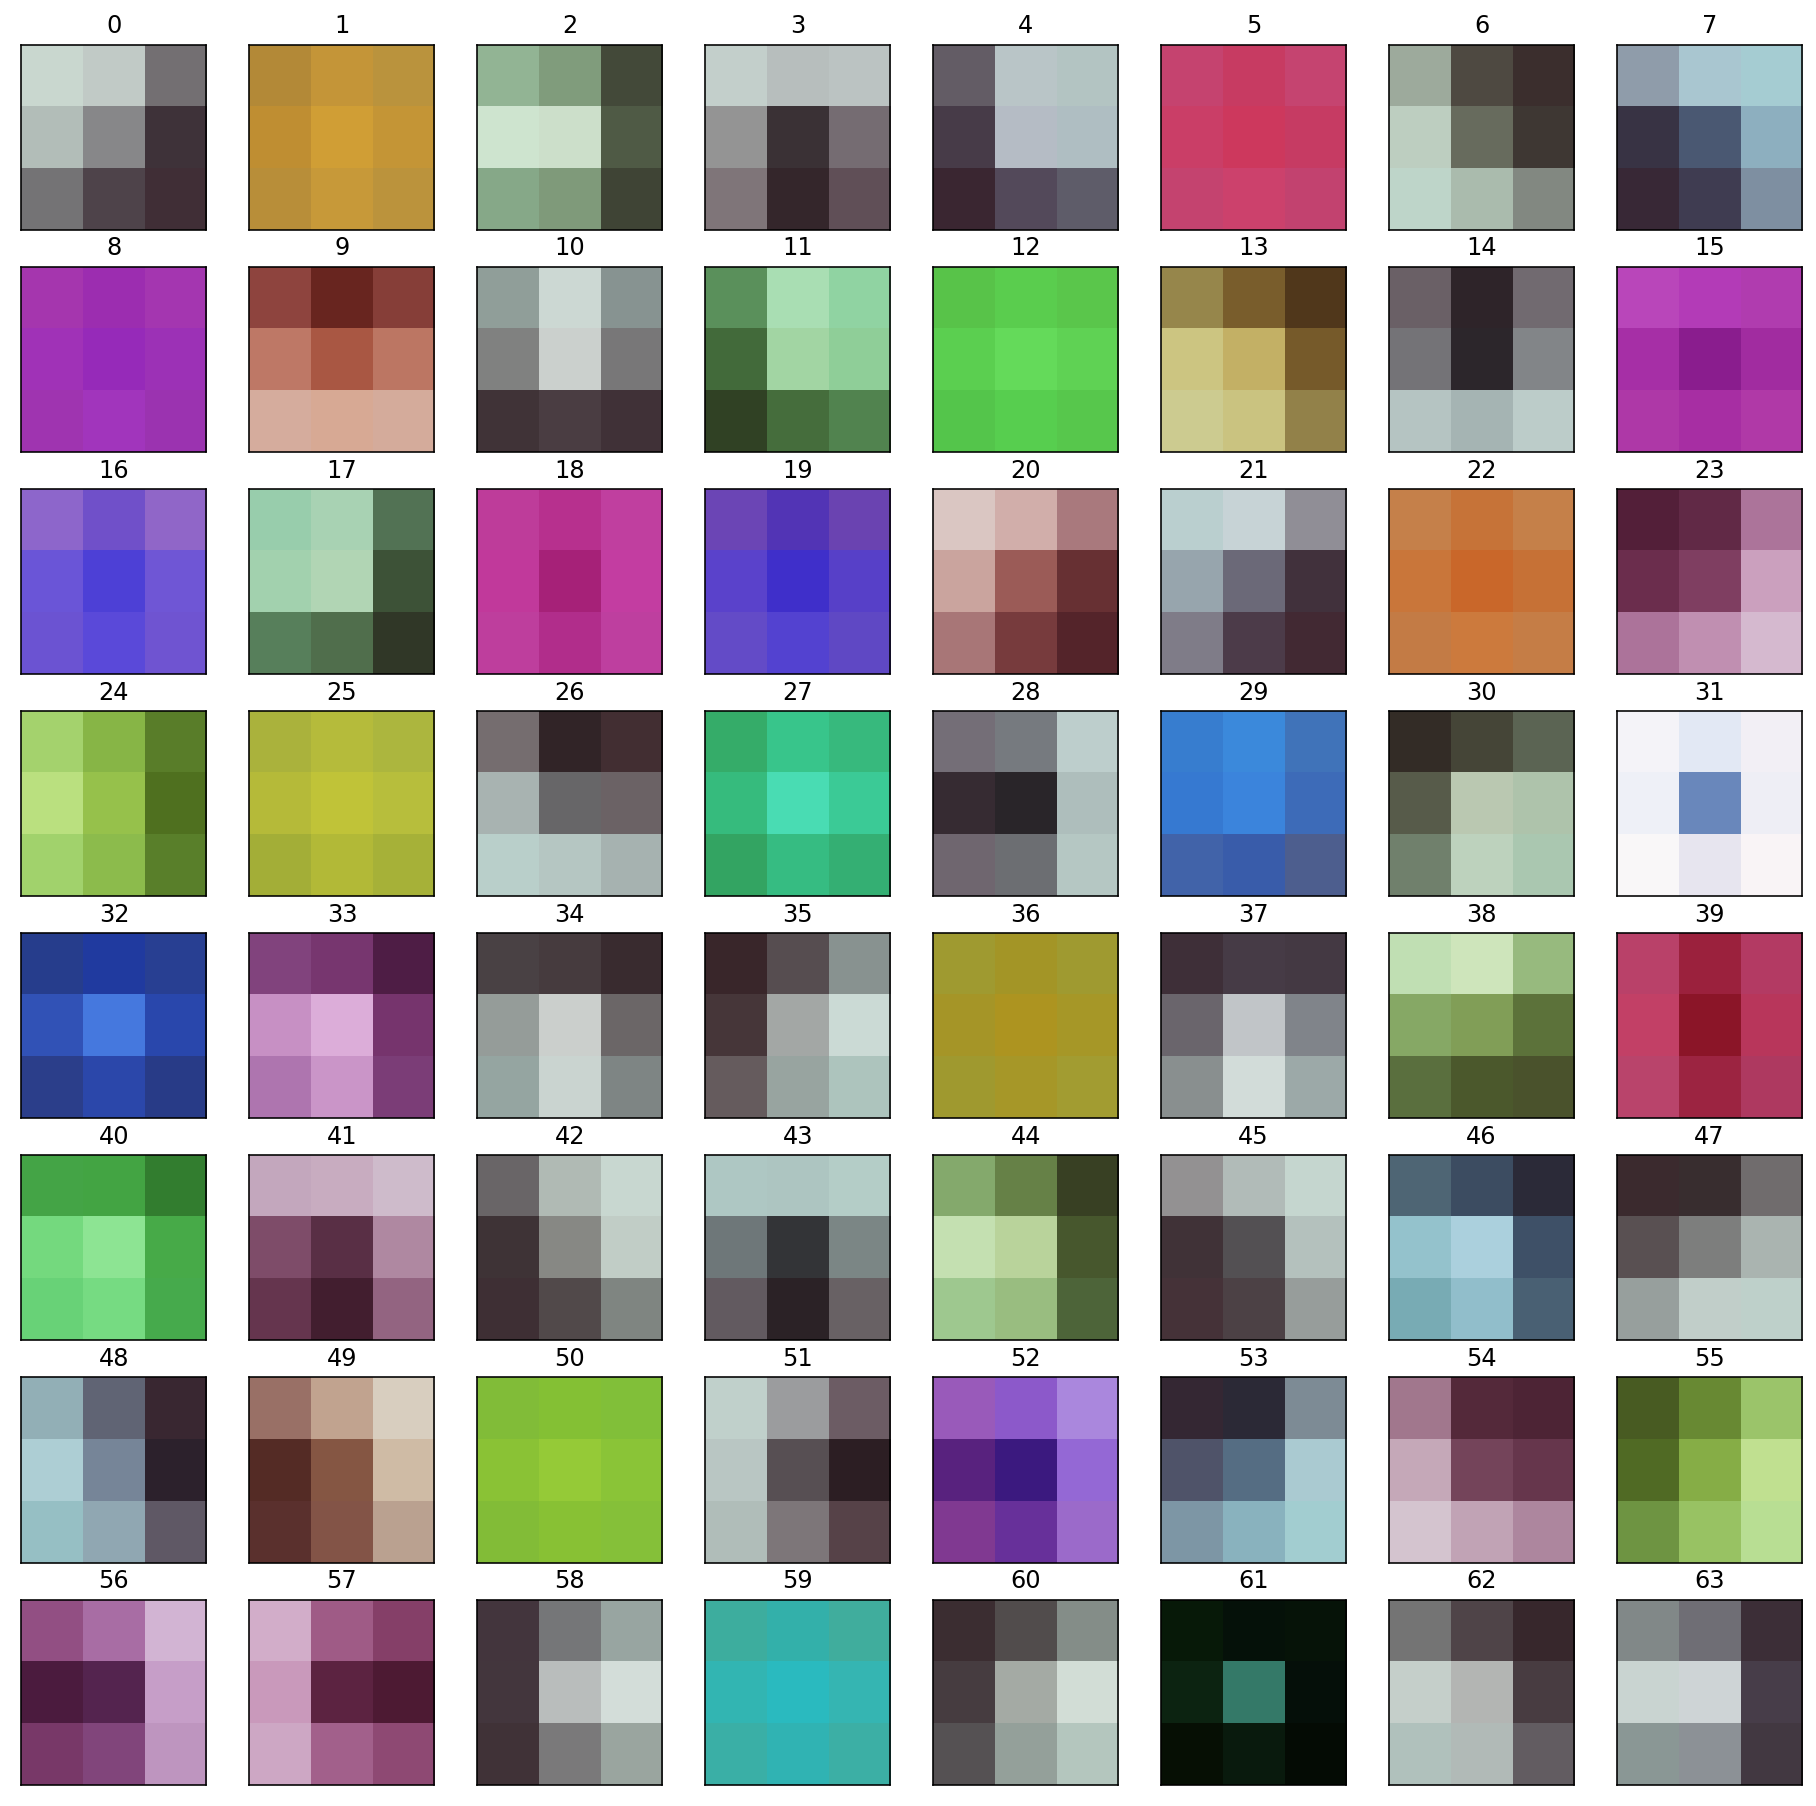

In [8]:
import numpy as pn
from utils import plot_conv_kernel
    
plot_conv_kernel(s.run(variables['block1_conv1/kernel:0']))

In [9]:
# In order to look at the activation map,
# we need to find the convolution operation first.
[op for op in s.graph.get_operations() if op.type == 'Conv2D']

[<tf.Operation 'block1_conv1/Conv2D' type=Conv2D>,
 <tf.Operation 'block1_conv2/Conv2D' type=Conv2D>,
 <tf.Operation 'block2_conv1/Conv2D' type=Conv2D>,
 <tf.Operation 'block2_conv2/Conv2D' type=Conv2D>,
 <tf.Operation 'block3_conv1/Conv2D' type=Conv2D>,
 <tf.Operation 'block3_conv2/Conv2D' type=Conv2D>,
 <tf.Operation 'block3_conv3/Conv2D' type=Conv2D>,
 <tf.Operation 'block4_conv1/Conv2D' type=Conv2D>,
 <tf.Operation 'block4_conv2/Conv2D' type=Conv2D>,
 <tf.Operation 'block4_conv3/Conv2D' type=Conv2D>,
 <tf.Operation 'block5_conv1/Conv2D' type=Conv2D>,
 <tf.Operation 'block5_conv2/Conv2D' type=Conv2D>,
 <tf.Operation 'block5_conv3/Conv2D' type=Conv2D>]

In [10]:
# If you need extra help finding the right operation,
# you can save the graph for Tensorboard.
# with tf.Session() as s:
#     tf.summary.FileWriter(
#         'tf_logs',
#         graph=s.graph,
#         session=s
#     ).close()

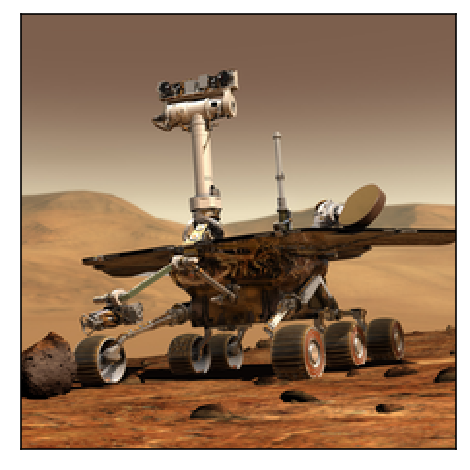

In [11]:
import numpy as np

def plot_input(image):
    plt.imshow(image / 255)
    plt.xticks([])
    plt.yticks([])

image_id = 3

# Let's select the first image.
image_start = images_resized[[image_id]]
plot_input(images_resized[image_id])

In [12]:
# Each Tensorflow operation has zero or more tensors that
# correspond to that operation's output. In the case
# of Conv2D operation, the 0th output is the activation map.
# We can extract those tensors by adding :0 to the operation name.
conv_tn = s.graph.get_tensor_by_name('block5_conv1/Conv2D:0')
relu_tn = s.graph.get_tensor_by_name('block5_conv1/Relu:0')
max_tn = s.graph.get_tensor_by_name('block5_pool/MaxPool:0')

# Each tensor is batch x height x width x channels,
# but since we only want to look at one image, we can drop others.
activation_volume_tn = max_tn[0]
activation_volume_tn.shape

TensorShape([Dimension(7), Dimension(7), Dimension(512)])

In [13]:
# In order to feed the network with image_start,
# the image has to be assigned to the input variable
# that was created passed into VGG16() constructor call.
s.run(tf.assign(input_tn, image_start))

# Now let's evaluate the activation volume tensor.
activation_volume = s.run(activation_volume_tn)

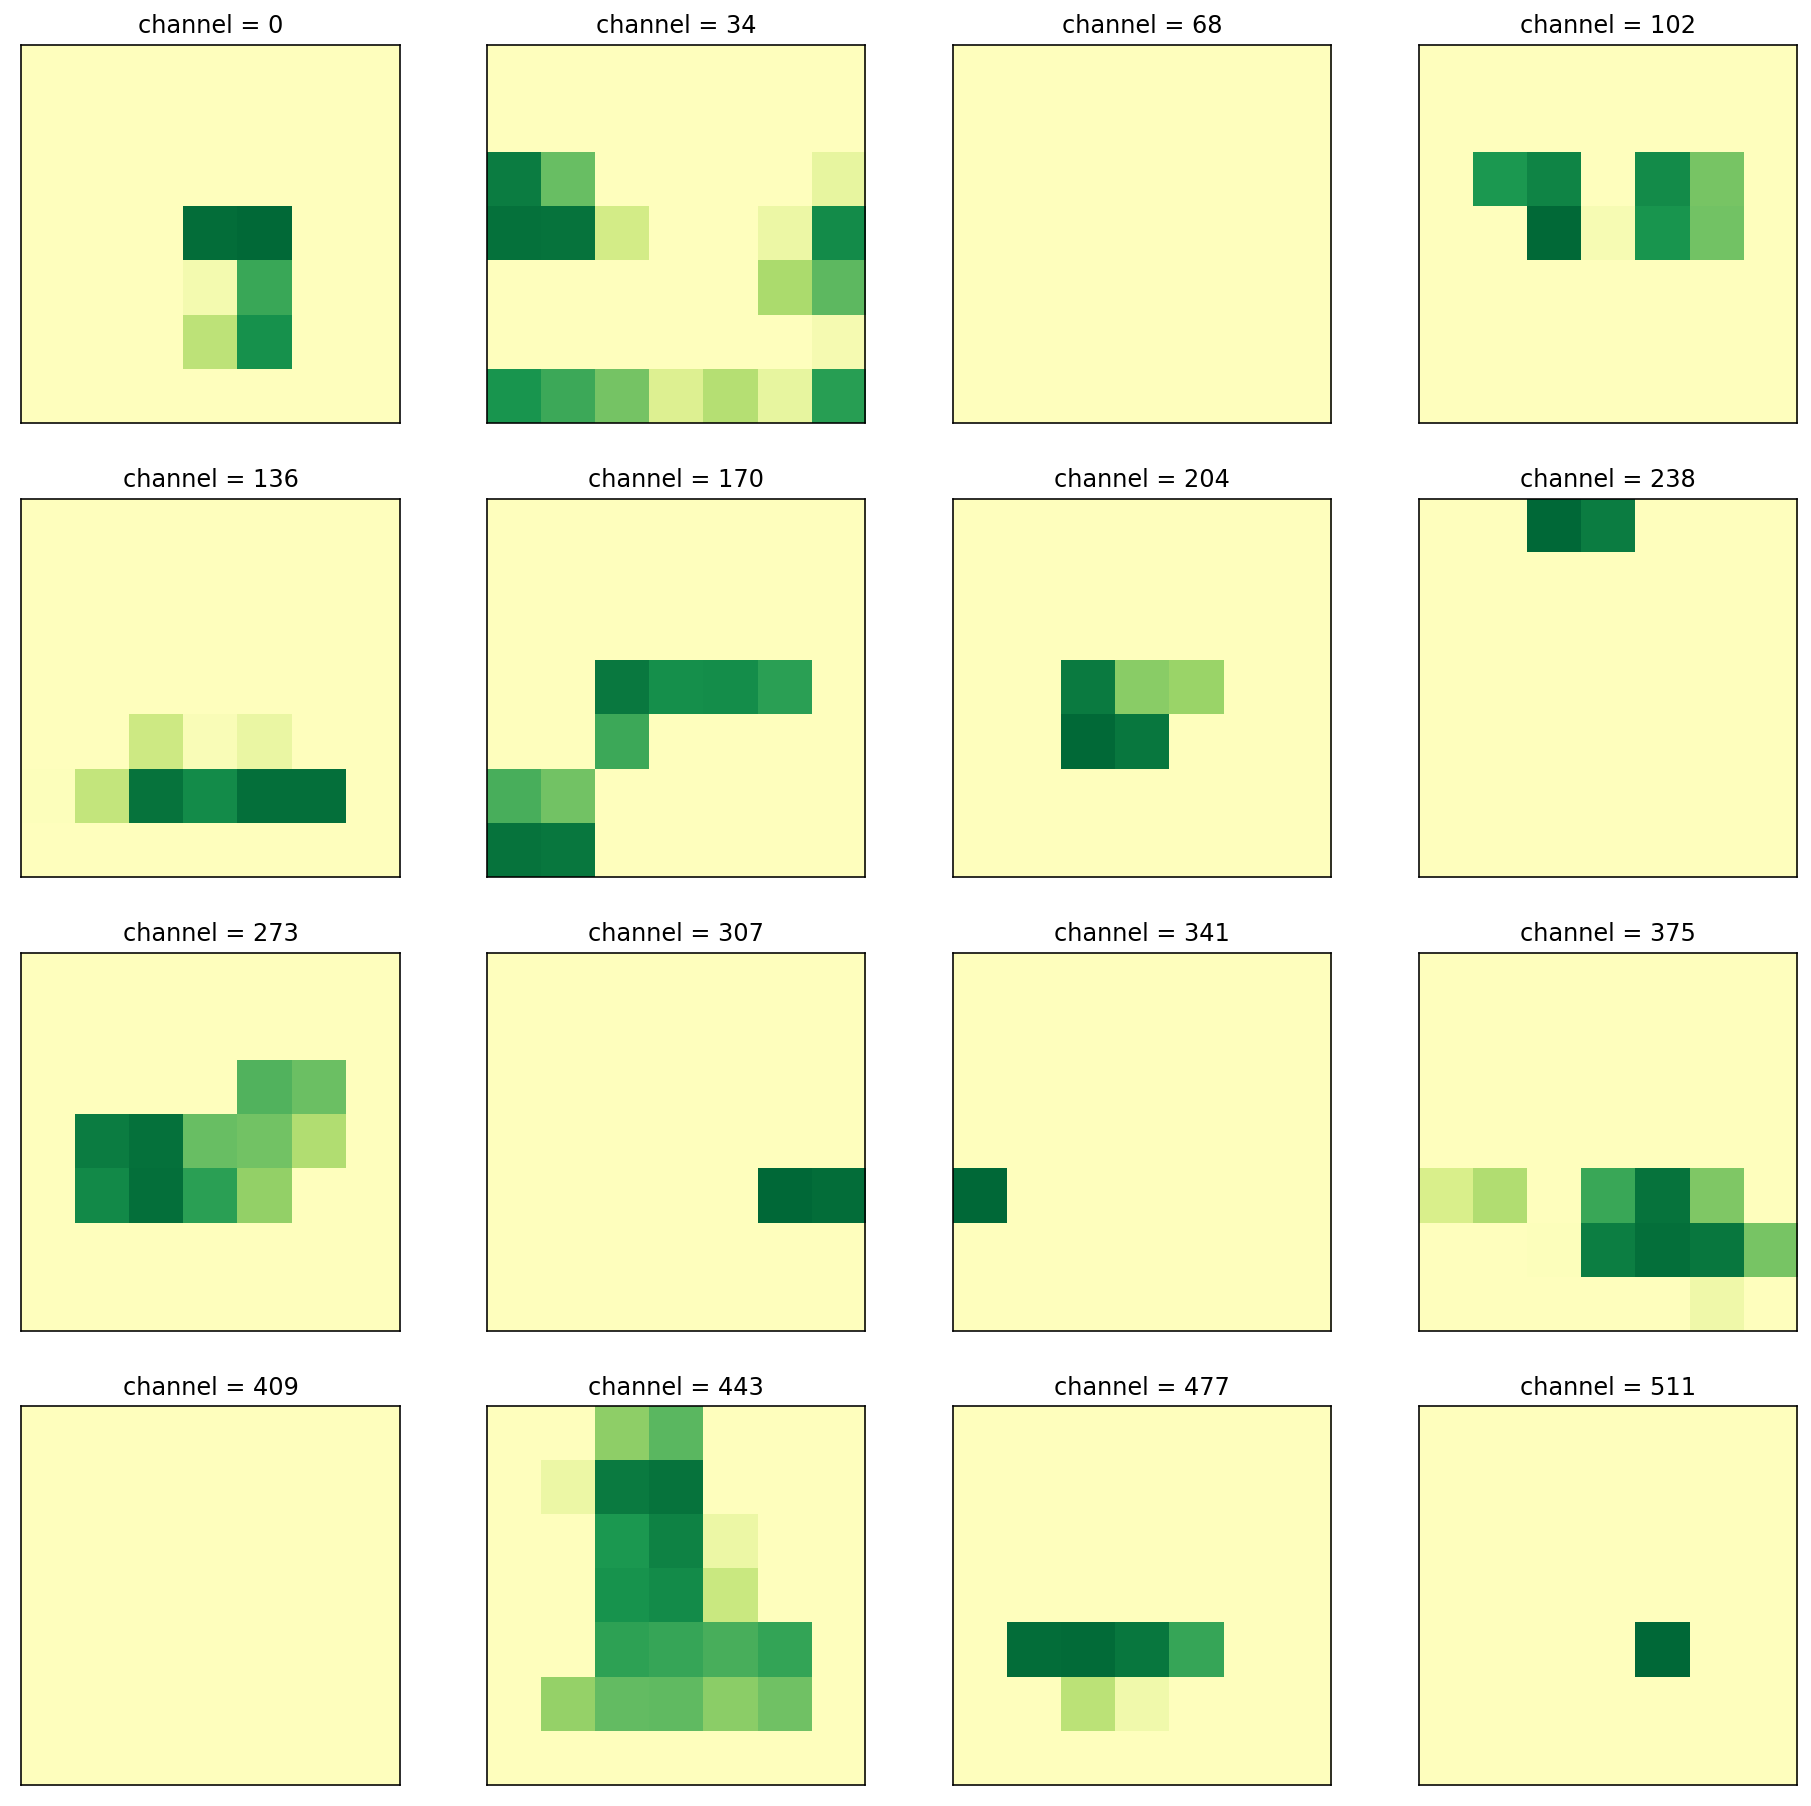

In [14]:
from utils import plot_activation_volume
plot_activation_volume(activation_volume, side=4)

In [15]:
filter_channel = 0
activation_map_tn = activation_volume_tn[:, :, filter_channel]
activation_map_tn.shape

TensorShape([Dimension(7), Dimension(7)])

In [16]:
cost_tn = -tf.reduce_mean(activation_map_tn) + 0.001 * tf.norm(input_tn)
gradient_op = tf.gradients(cost_tn, input_tn)

learning_rate = 10000
new_image_tn = input_tn - learning_rate * gradient_op[0]
new_image_tn = tf.clip_by_value(new_image_tn, 0, 255)

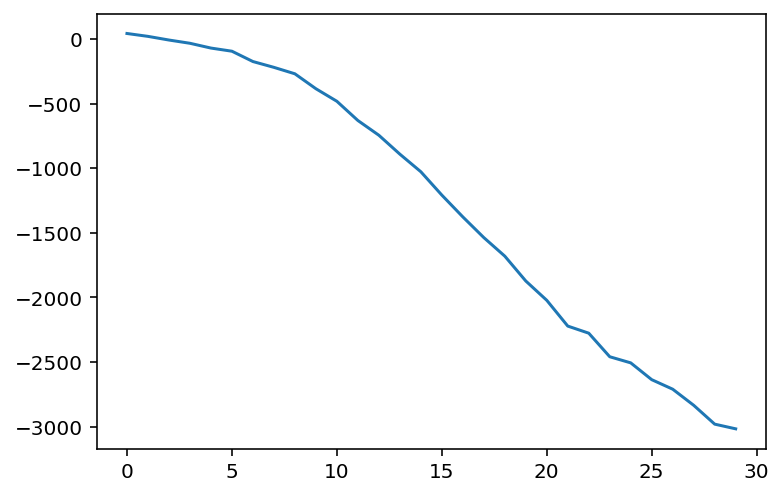

In [17]:
import seaborn as sns
gradients = []
learning_curve = []
activations = []
images = []

image_current = image_start
for i in range(30):
    images.append(image_current[0])
    s.run(input_tn.assign(image_current))
    image_new, activation, cost, grad = s.run([
        new_image_tn, 
        activation_map_tn, 
        cost_tn, 
        gradient_op
    ])
    
    gradients.append(grad)
    learning_curve.append(cost)
    activations.append(activation)
    
    image_current = image_new
    
sns.lineplot(range(len(learning_curve)), learning_curve)

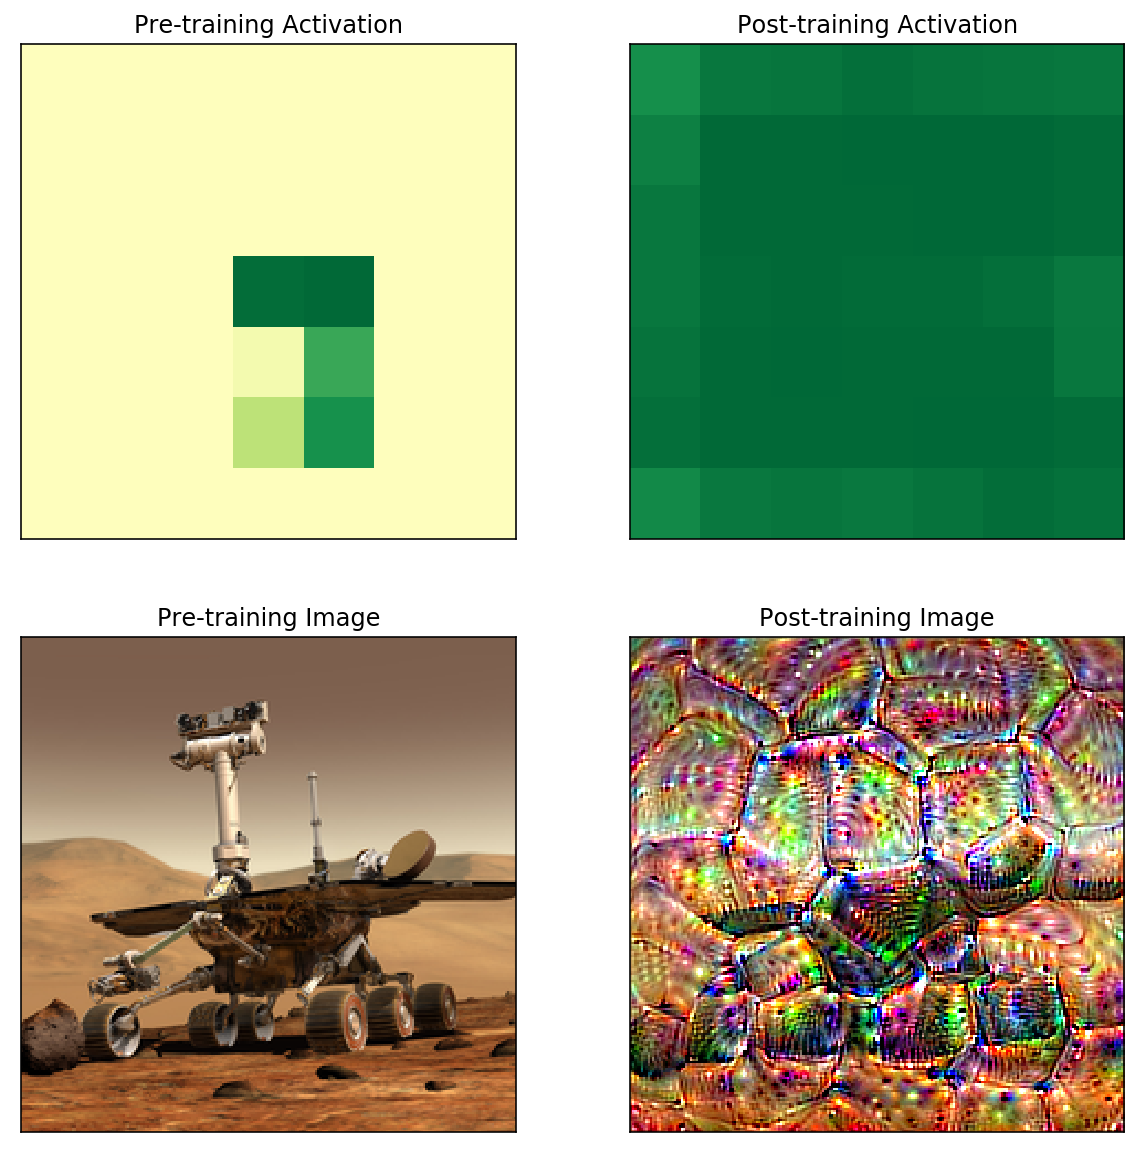

In [19]:
from utils import plot_activation_map

plt.figure(figsize=[10, 10])

plt.subplot(2, 2, 1)
plt.title('Pre-training Activation')
plot_activation_map(activations[0])
plt.subplot(2, 2, 2)
plt.title('Post-training Activation')
plot_activation_map(activations[-1])
plt.subplot(2, 2, 3)
plt.title('Pre-training Image')
plot_input(images[0])
plt.subplot(2, 2, 4)
plt.title('Post-training Image')
plot_input(images[-1])

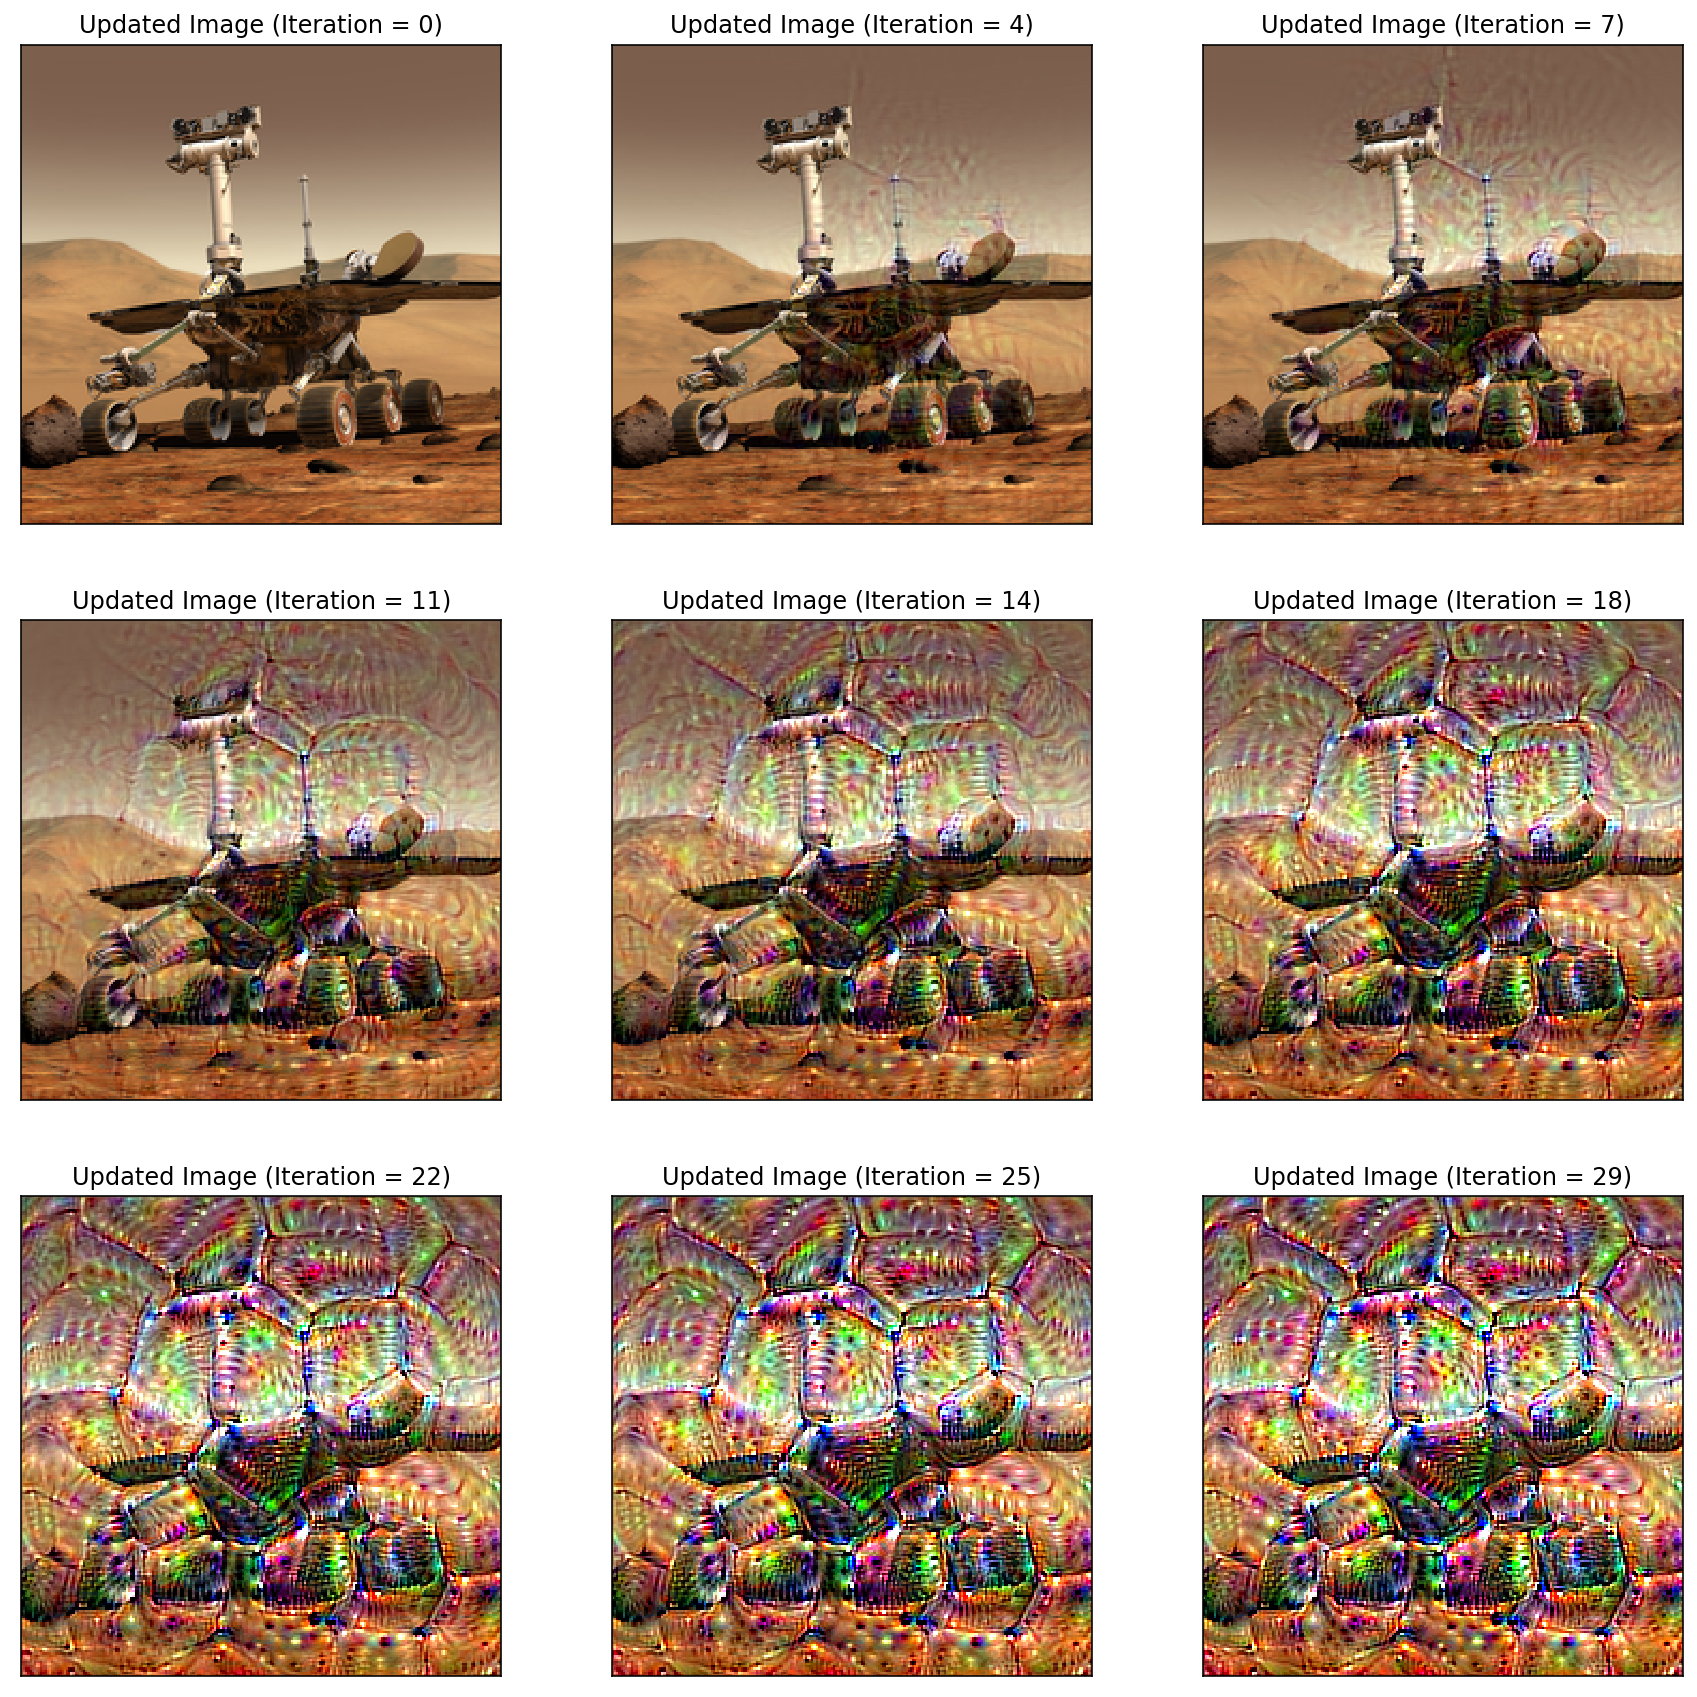

In [20]:
nrows = 3
ncols = 3
idxs = np.linspace(0, len(images)-1, 9).round().astype(int)

plt.figure(figsize=[5 * ncols, 5 * nrows])
for i, idx in enumerate(idxs):
    plt.subplot(nrows, ncols, i+1)
    plot_input(images[idx])
    plt.title(f'Updated Image (Iteration = {idx})')

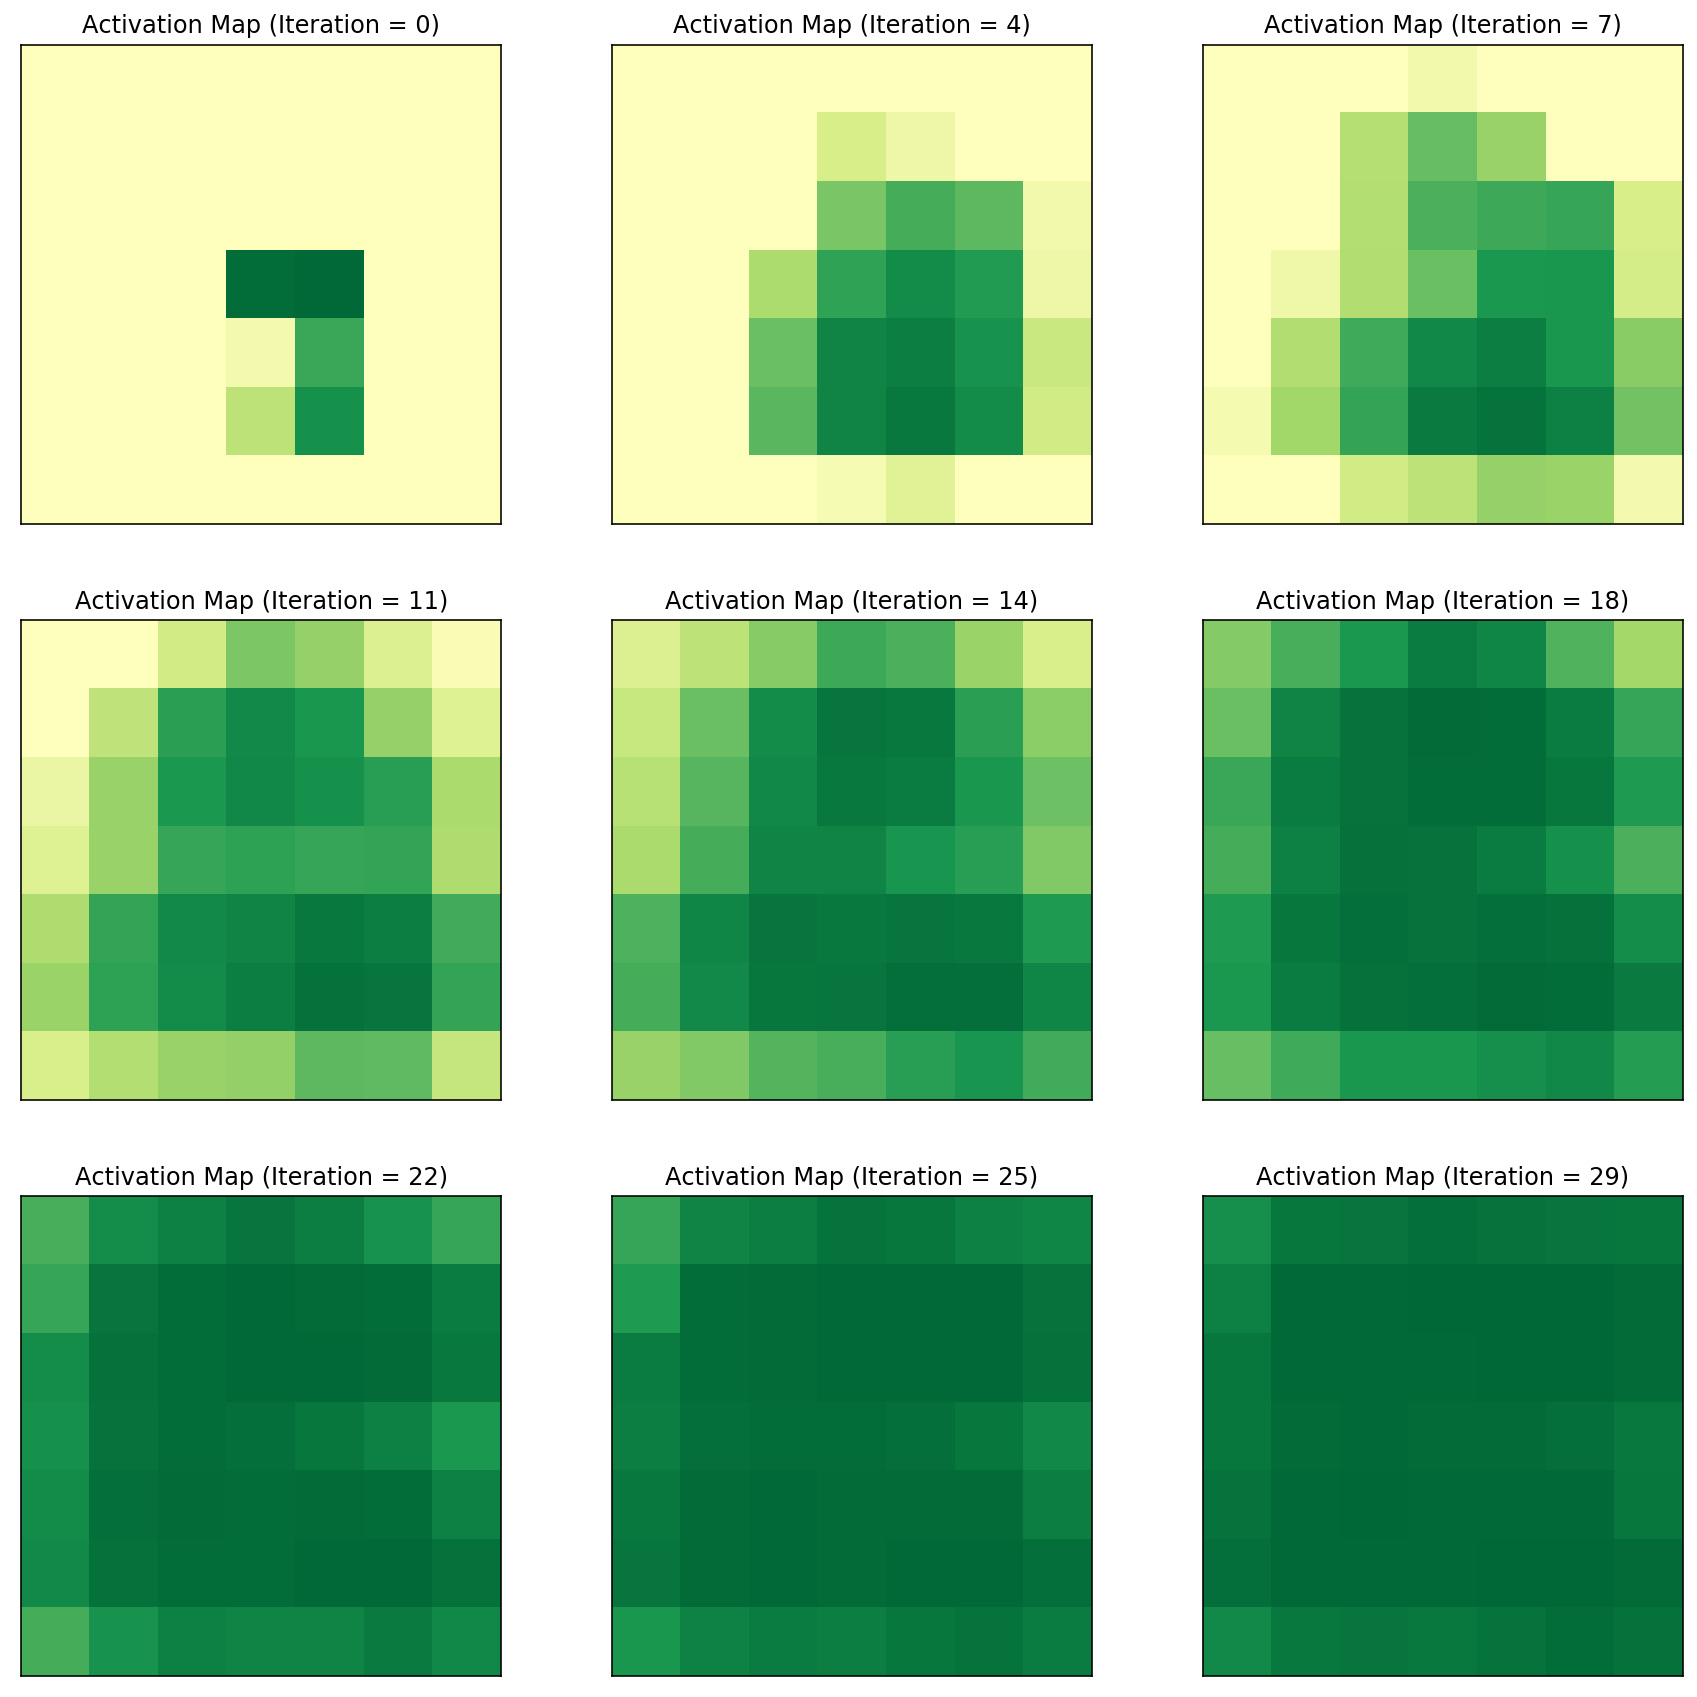

In [21]:
nrows = 3
ncols = 3
idxs = np.linspace(0, len(activations)-1, 9).round().astype(int)

plt.figure(figsize=[5 * ncols, 5 * nrows])
for i, idx in enumerate(idxs):
    plt.subplot(nrows, ncols, i+1)
    plot_activation_map(activations[idx])
    plt.title(f'Activation Map (Iteration = {idx})')

In [22]:
activations[0].mean(), activations[-1].mean()

(0.29098576, 4.458808)

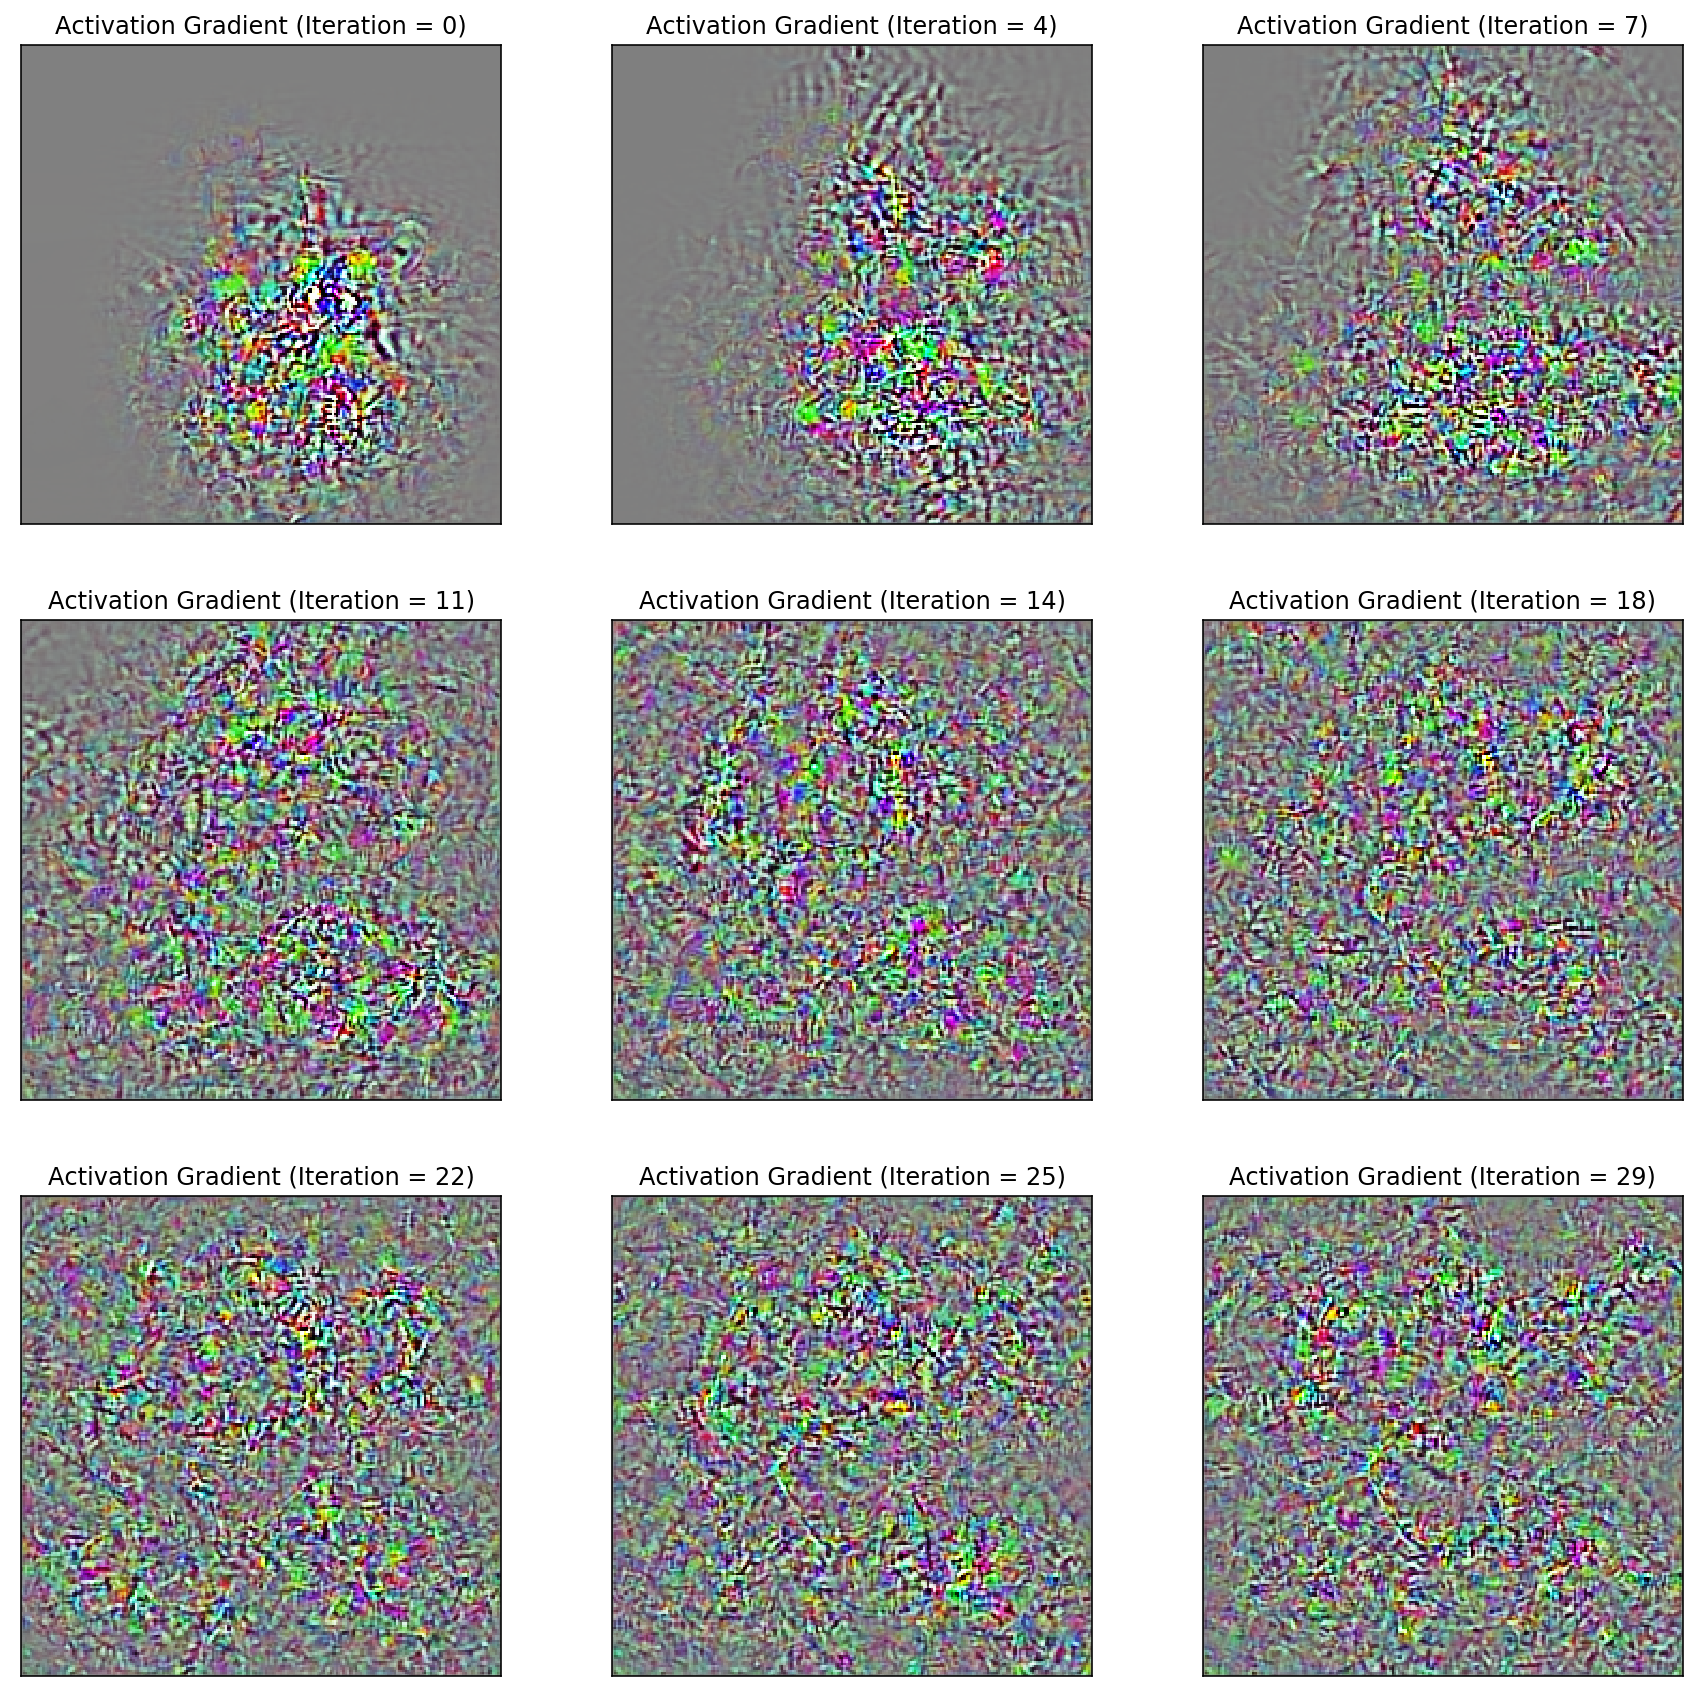

In [23]:
from utils import plot_gradient

nrows = 3
ncols = 3
idxs = np.linspace(0, len(gradients)-1, nrows*ncols).round().astype(int)

plt.figure(figsize=[5 * ncols, 5 * nrows])
for i, idx in enumerate(idxs):
    plt.subplot(nrows, ncols, i+1)
    grad = gradients[idx][0][0]
    plot_gradient(grad)
    plt.title(f'Activation Gradient (Iteration = {idx})')

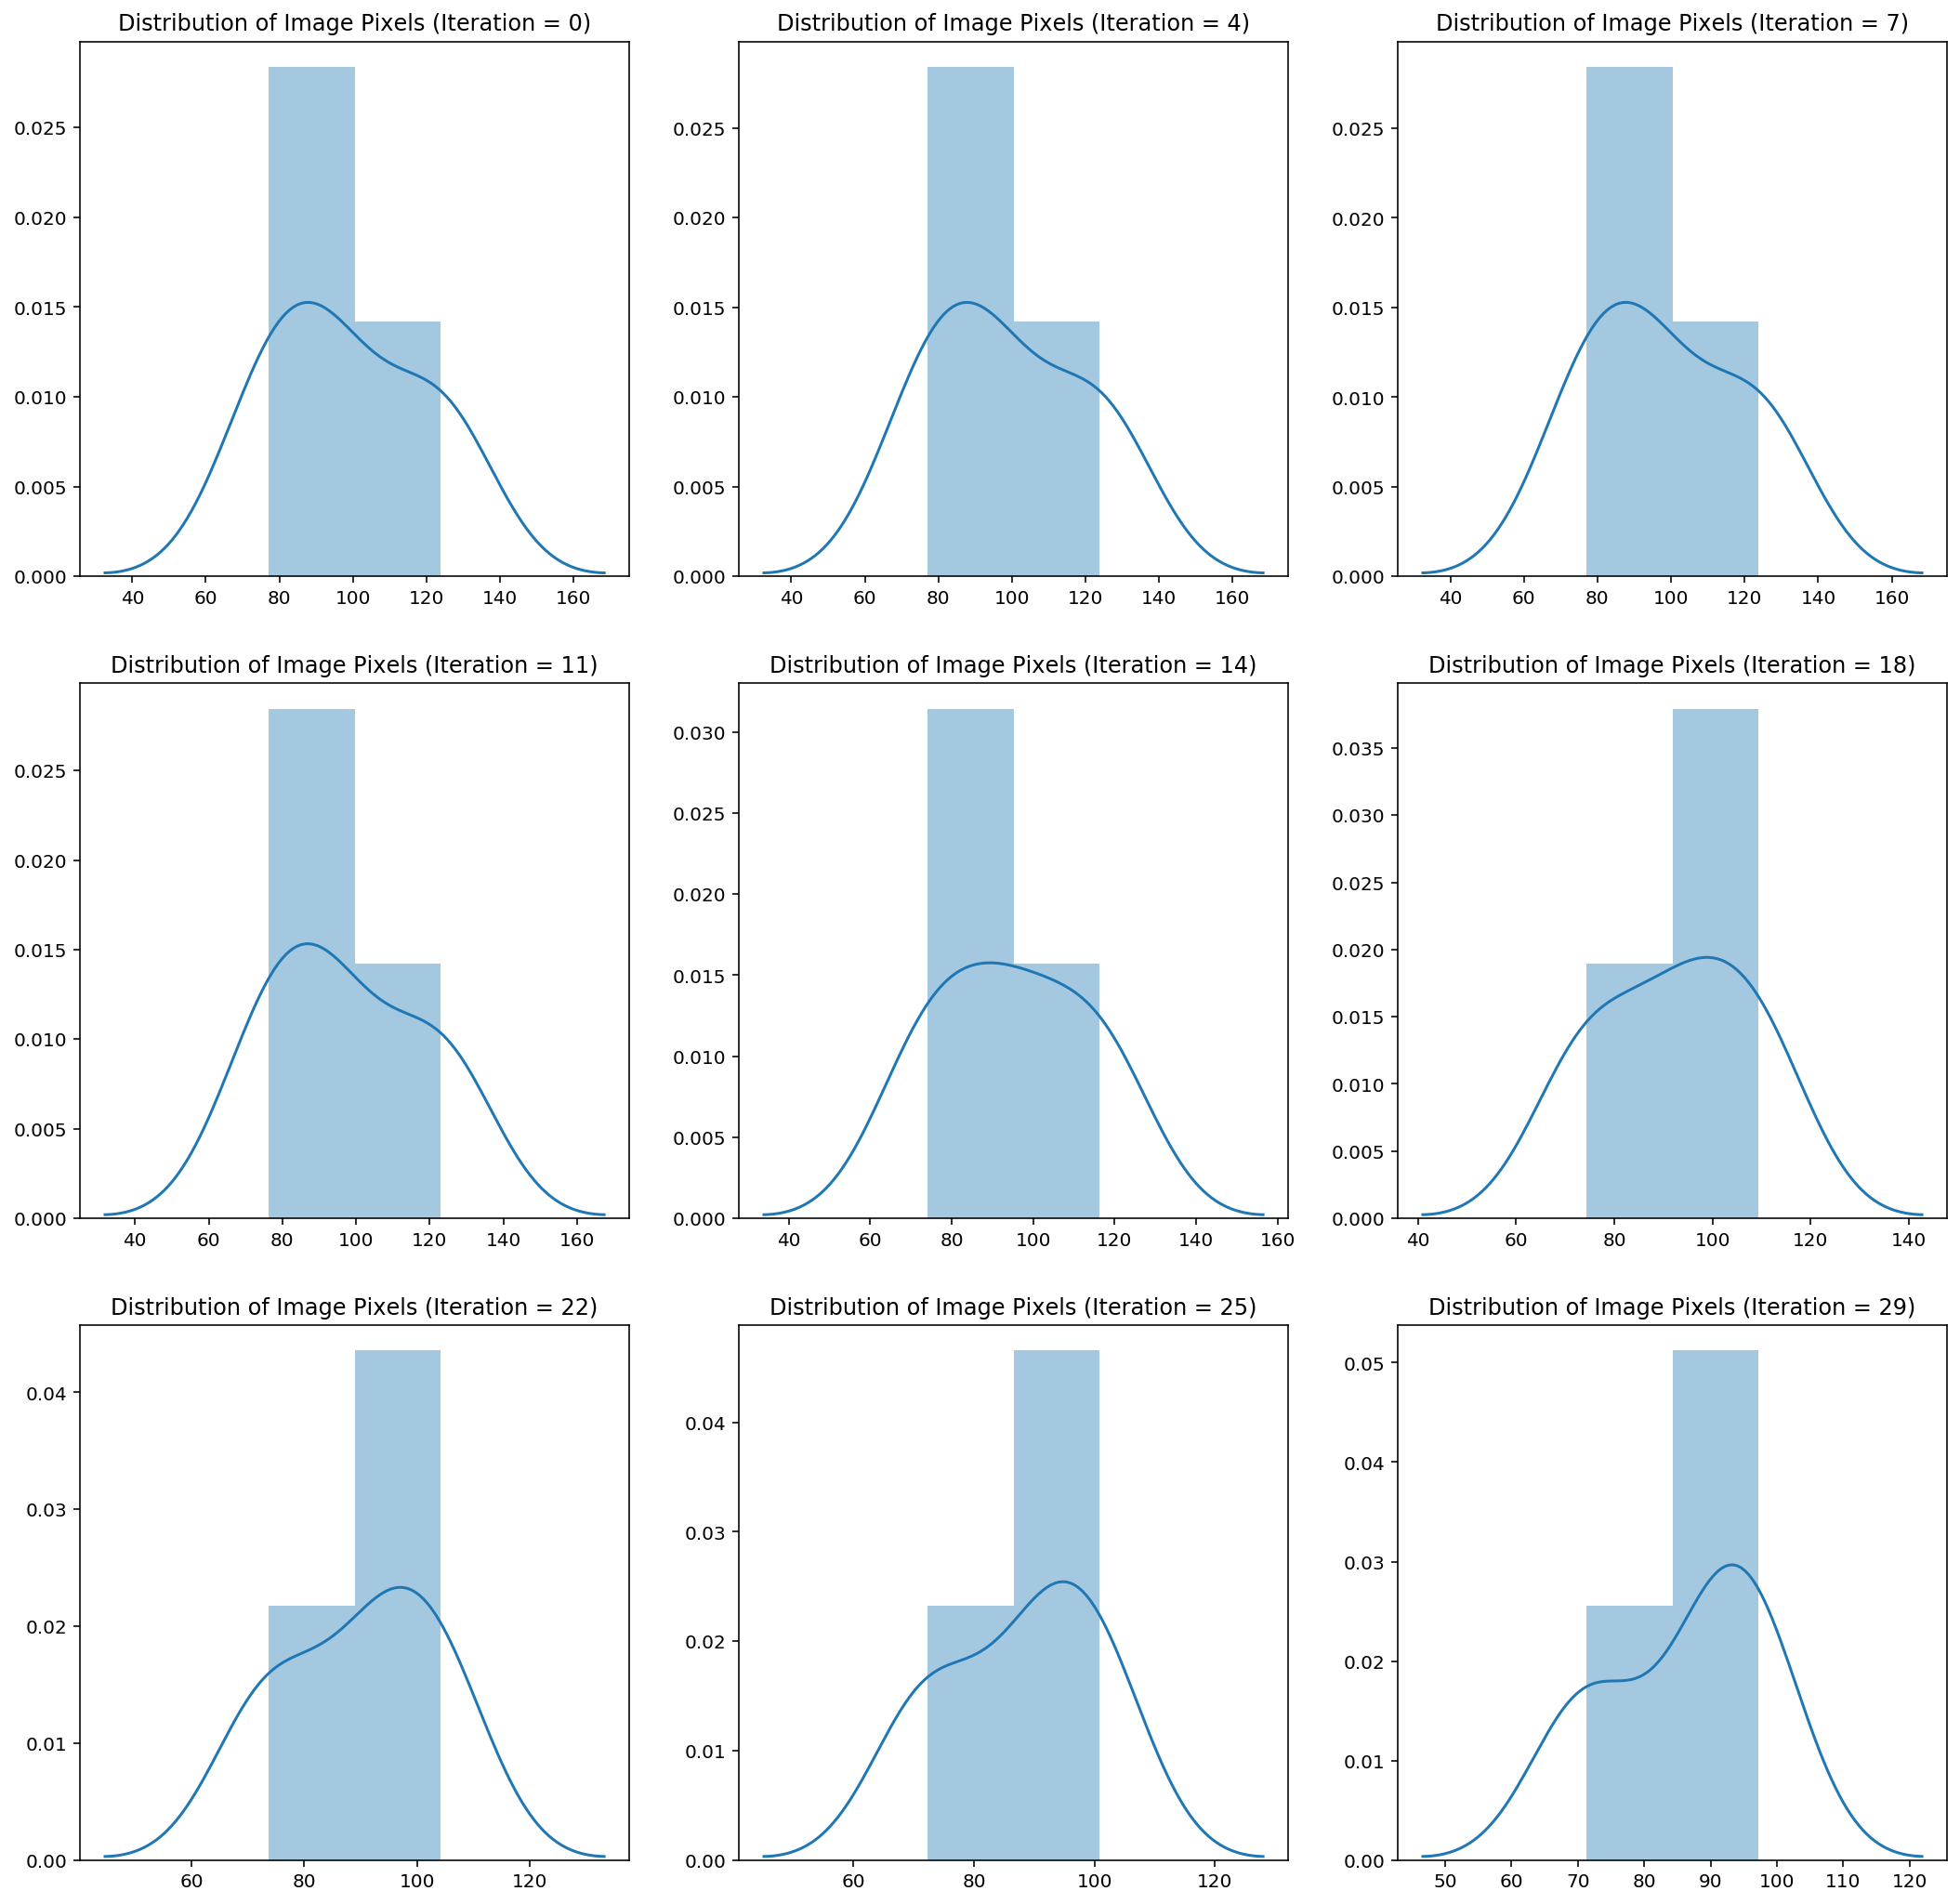

In [24]:
import seaborn as sns
import math

nrows = 3
ncols = 3
idx = np.linspace(0, len(images)-1, 9).round().astype(int)

plt.figure(figsize=[6*ncols, 6*nrows])
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.title(f'Distribution of Image Pixels (Iteration = {idx[i]})')
    sns.distplot(images[idx[i]][0][0].reshape(-1))

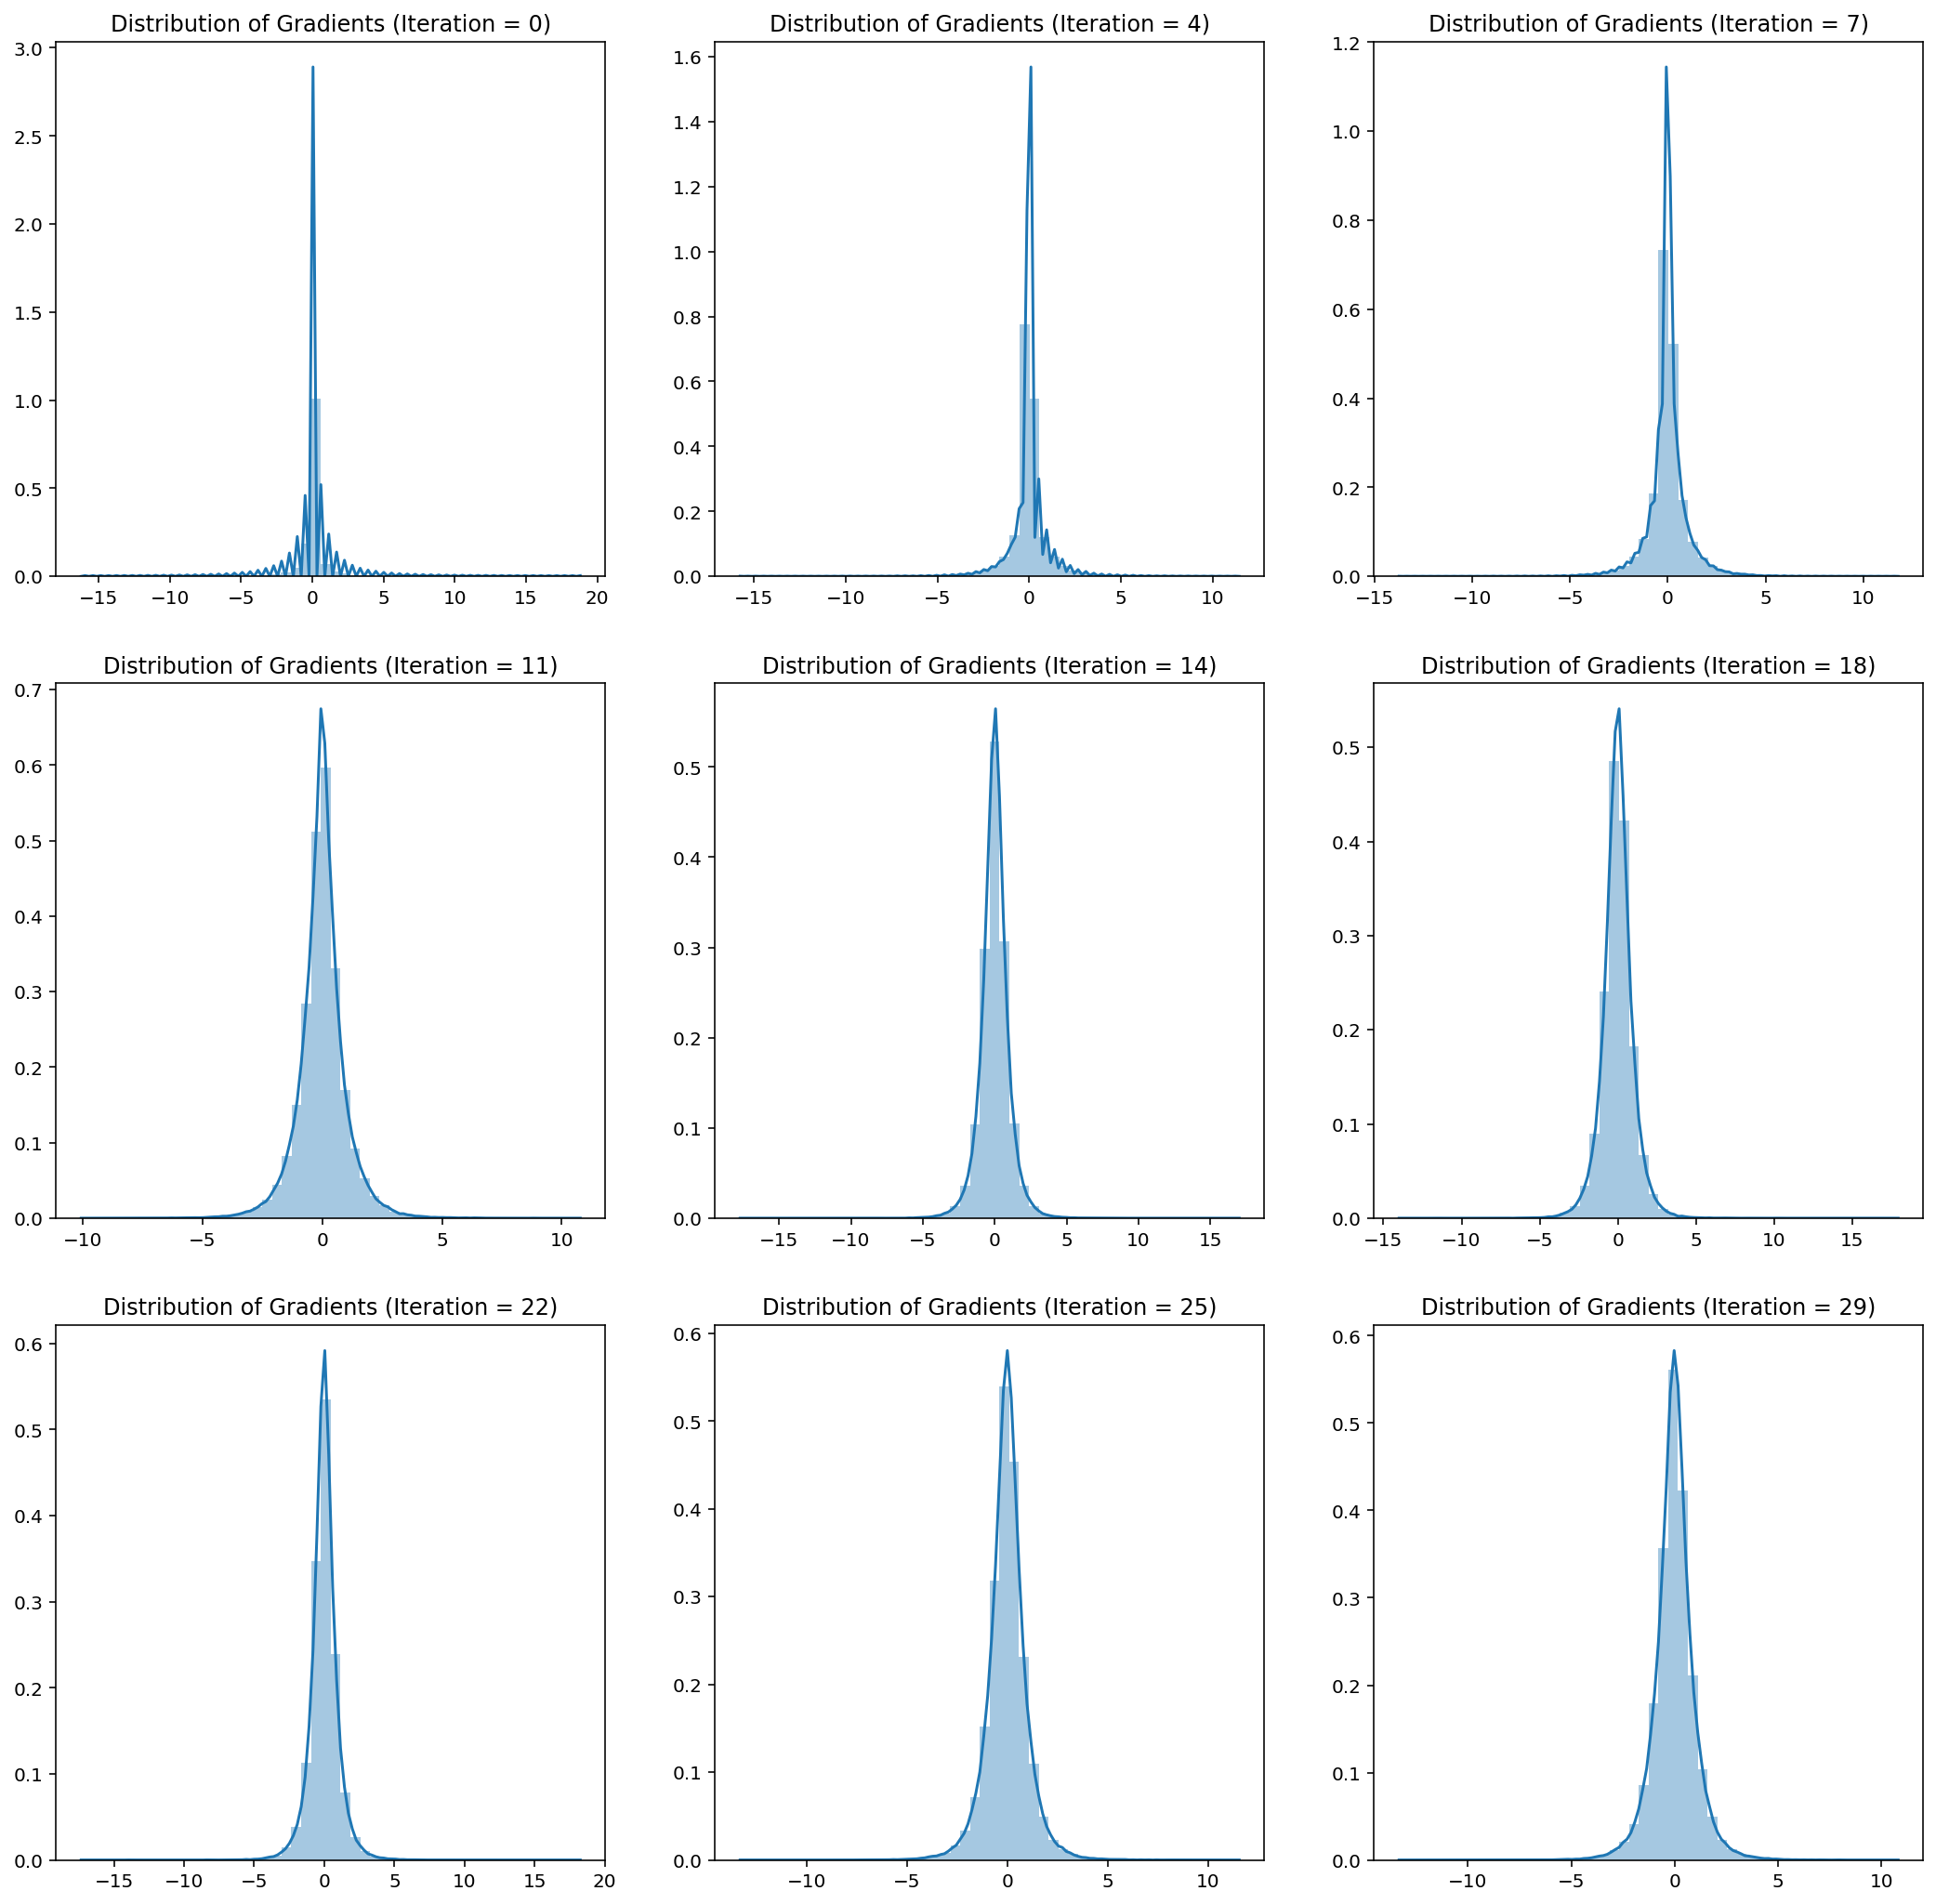

In [25]:
import seaborn as sns
import math

nrows = 3
ncols = 3
idxs = np.linspace(0, len(gradients)-1, ncols*nrows).round().astype(int)

plt.figure(figsize=[6*ncols, 6*nrows])
for i, idx in enumerate(idxs):
    plt.subplot(nrows, ncols, i+1)
    plt.title(f'Distribution of Gradients (Iteration = {idx})')
    sns.distplot(gradients[idx][0][0].reshape(-1))

In [26]:
from PIL import Image
import os

previous_dreams = [
    int(n.split('dream')[1]) for n in os.listdir('.') 
    if n.startswith('dream')
]

if len(previous_dreams) > 0:
    next_dream = max(previous_dreams) + 1
else:
    next_dream = 0

os.system(f'mkdir -p dream{next_dream}')
for idx, image in enumerate(images):
    Image.fromarray(image.astype('uint8')).save(f'dream{next_dream}/{idx}.png')